In [ ]:
# WINDOW_GIVEN = 89
# WINDOW_SIZE = 90
# =========

# 모델성능
# N_HIDDENS = 100 # perceptron수
# N_LAYERS = 3 # 레이어 층수 
# BATCH_SIZE = 512 # computing 속도.

# n_epochs=40

# early stop
# learningrate 조절
# ====

# 평가성능
# THRESHOLD = 0.060

# function ClickConnect(){
#     console.log("1분마다 코랩 연결 끊김 방지"); 
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect-icon")
# .click();
# }
# setInterval(ClickConnect, 1000 * 60);

In [1]:
!nvidia-smi

Mon Sep  6 02:45:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# 최종 Evaluate Package 설치
!pip install ./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/eTaPR-21.8.2-py3-none-any.whl

Processing ./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/eTaPR-21.8.2-py3-none-any.whl


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import torch
from torch.utils.data import Dataset, DataLoader

# from keras.models import Model, Sequential, load_model
# import keras
# from keras import optimizers
# from keras.layers import Input,Bidirectional ,LSTM, Dense, Activation
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from sklearn.metrics import mean_squared_error
# import tensorflow as tf
# from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import pickle
import sys
from pathlib import Path
from datetime import timedelta
import dateutil
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [5]:
# !pip freeze > ./gdrive/MyDrive/멋사_study/HAICon2021/requirements.txt

In [6]:
# Data Path Load
path_train = sorted([x for x in Path("./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/train").glob("*.csv")]) 
path_test = sorted([x for x in Path("./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/test").glob("*.csv")]) 
path_validation = sorted([x for x in Path("./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/validation").glob("*.csv")]) 

In [7]:
def csv_to_df(target):
    return pd.read_csv(target)

def df_data_load(targets):
    return pd.concat([csv_to_df(x) for x in targets])

# Min-Max Regularization
def normalize(raw):
    ndf = raw.copy()
    for c in raw.columns:
        #min-max가 0인경우에는 무의미한 col으로 생각하고, 0으로 채워줌
        if raw_train[useful_cols].min()[c] == raw_train[useful_cols].max()[c]:
            ndf[c] = raw[c] - raw_train[useful_cols].min()[c]
        else:
            ndf[c] = (raw[c] - raw_train[useful_cols].min()[c]) / (raw_train[useful_cols].max()[c] - raw_train[useful_cols].min()[c])
    return ndf

# min_max reg를 진행하고, boundary인 [0,1] 이외의 값이 존재하는지 체크하는 함수
# train data에 대해서는, Reguralizaion 제대로 됐는지 체크
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [8]:
raw_train = df_data_load(path_train) # timestamp,C01~C86
raw_validation = df_data_load(path_validation) # timestamp,C01~C86, attack
raw_test = df_data_load(path_test) # timestamp,C01~C86

# time stamp는 attack event와 관련이 없는 관계로 삭제한다.
# time stamp는 normalize 시에 에러 발생

useful_cols = raw_train.columns.drop('timestamp')
useful_cols

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [ ]:
# # Exponential Weighted Function 통과
# # 센서에서 발생하는 noise를 **smoothing** 시켜주기 위해 적용
# df_train= normalize(raw_train[useful_cols]).ewm(alpha=0.9).mean()

In [ ]:
# df_validation = normalize(raw_validation[useful_cols])

In [ ]:
# df_test= normalize(raw_test[useful_cols]).ewm(alpha=0.9).mean()

In [ ]:
# df_train.to_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_train.pickle")
# df_validation.to_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_validation.pickle")
# df_test.to_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_test.pickle")

# normalize 완료된 df 불러오기

In [9]:
# normalize 완료된 df 불러오기
df_train = pd.read_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_train.pickle")
df_validation = pd.read_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_validation.pickle")
df_test = pd.read_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_test.pickle")

print(boundary_check(df_train))
print(boundary_check(df_validation))
print(boundary_check(df_test))

(False, False, False)
(True, True, False)
(True, True, False)


# HaiDataset 저장/불러오기

In [10]:
# Model의 출력값과 실제 값의 차이가 클 때 이상상황으로 정의
# Stacked RNN(GRU cells)
# Unsupervised Learning
# shingle size = 90


WINDOW_SIZE = 50
WINDOW_GIVEN = WINDOW_SIZE-1


class HaiDataset(Dataset): # pytorch의 Dataset class 활용
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32) # dataset을 array로 바꾼거.
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1): # L 1번째,  100번째 ts 9461번째
            R = L + WINDOW_SIZE - 1 # R 60번째, 159번째. 10000번째.
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse( # 60번째-1번째 = 59 . 이게 윈도우사이즈 크기와 동일한지 점검하는 조건
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L) # valid idx에 L시점의 ts를 쭉 저장. 1~9461 저장(리스트형태로)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride] # valid idx array 형태로 바꿔주기
        self.n_idxs = len(self.valid_idxs) # n_idxs 는 갯수.
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32) # attack이 있으면 self.attacks함수에 Attack 표시나게하고
            self.with_attack = True # with_attack함수로 boolean 검증
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs # n_idxs WIndow에서 왼쪽 bounday가 될 수 있는 ts 갯수.

    def __getitem__(self, idx): ## slicing을 구현하기 위한 메소드
        i = self.valid_idxs[idx] # Left boundary
        last = i + WINDOW_SIZE - 1 # Right boundary
        item = {"attack": self.attacks[last]} if self.with_attack else {} # with_attack이 true면 item에 attack 표기 (right boundary기준)
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN]) # left boundary부터, right bounday까지, 80개의 window boundary안에있는 모든 데이터 값.
        item["answer"] = torch.from_numpy(self.tag_values[last]) # given의 마지막 row 는 그 이전 스텝의 answer의 값과 동일하다.
        return item

In [ ]:
# train_data = HaiDataset(raw_train['timestamp'],df_train, stride=1)
# validation_data = HaiDataset(raw_validation['timestamp'],df_validation, stride=1)
# test_data = HaiDataset(raw_test['timestamp'],df_test, stride=1)

In [11]:
# import pickle
# # # HaiDataset 저장
# with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/HaiDataset/train_data_{}".format(WINDOW_SIZE), "wb" ) as file:
#     pickle.dump( train_data, file)
# with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/HaiDataset/validation_data_{}".format(WINDOW_SIZE), "wb" ) as file:
#     pickle.dump( validation_data, file)
# with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/HaiDataset/test_data_{}".format(WINDOW_SIZE), "wb" ) as file:
#     pickle.dump( test_data, file)

# HaiDataset 불러오기
with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/HaiDataset/train_data_{}".format(WINDOW_SIZE), "rb" ) as file:
    train_data = pickle.load(file)

with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/HaiDataset/validation_data_{}".format(WINDOW_SIZE), "rb" ) as file:
    validation_data = pickle.load(file)

with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/HaiDataset/test_data_{}".format(WINDOW_SIZE), "rb" ) as file:
    test_data = pickle.load(file)

## 모델링 시작

In [13]:
N_HIDDENS = 2 # perceptron수
N_LAYERS = 1
BATCH_SIZE = 512

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__() # torch.nn.Module에 담겨있는 함수를 사용하겠다.
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,# perceptron수
            num_layers=N_LAYERS,
            bidirectional=True, #양방향으로 할지 말지 forward + backward 두번씩 하니까 feature가 두배로 변함
            dropout=0,
            # batch_first = True # batch_first : 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부. (False가 기본값)
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [36]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Dataloader는 Mini Batch만들어 주는 역할. # 전체 데이터가 mini batch Size로 슬라이스됨. 
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) # AdamW를 Optimizer로 선언
    loss_fn = torch.nn.MSELoss() #MSE로 Loss function 설정
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max} # float으로 설정할 수 있는 값중 최대값 지정
    loss_history = []
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.997)
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        lr_scheduler.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
        directory = "/content/gdrive/MyDrive/멋사_study/HAICon2021/model/model_W{}_B{}_P{}_D{}_E{}".format(WINDOW_SIZE,BATCH_SIZE,N_HIDDENS,N_LAYERS,n_epochs)
        file_path = '/epoch{}_LOSS{:.6f}.pt'.format(e, epoch_loss)
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open(directory+file_path, "wb") as f:
          torch.save({
              'epoch': e + 1,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': epoch_loss,
              }, f)
          
        print(f"epochs : {e+1:.0f}, loss : {epoch_loss:.4f}")
    return best, loss_history

In [37]:
MODEL = StackedGRU(n_tags=df_train.shape[1]) # input사이즈를 train data columns수로 하겠다는뜻
MODEL.cuda() # GPU 메모리 할당

StackedGRU(
  (rnn): GRU(86, 2, bidirectional=True)
  (fc): Linear(in_features=4, out_features=86, bias=True)
)

In [38]:
%%time
n_epochs = 1
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(train_data, MODEL, BATCH_SIZE,n_epochs=n_epochs)

training:   0%|          | 0/1 [00:00<?, ?it/s]

epochs : 1, loss : 27.5422
CPU times: user 1min, sys: 588 ms, total: 1min
Wall time: 1min


### 모델 불러오기

In [ ]:
# with open("/content/gdrive/MyDrive/멋사_study/HAICon2021/model/model_W{}_B{}_P{}_D{}_E{}.pt".format(WINDOW_SIZE,BATCH_SIZE,N_HIDDENS,N_LAYERS,n_epochs), "wb") as f:
#     torch.save(
#         {
#             "state": BEST_MODEL["state"],
#             "best_epoch": BEST_MODEL["epoch"],
#             "loss_history": LOSS_HISTORY,
#         },
#         f,
#     )

In [ ]:
# n_epochs = 20

In [ ]:
directory = "/content/gdrive/MyDrive/멋사_study/HAICon2021/model/model_W{}_B{}_P{}_D{}_E{}".format(WINDOW_SIZE,BATCH_SIZE,N_HIDDENS,N_LAYERS,n_epochs)
# with open(directory+"/선택할 epoch파일명.pt", "rb") as f:
with open(directory+"/선택하는path.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])


# 변수명 SAVED_MODEL

<All keys matched successfully>

In [ ]:
SAVED_MODEL["best_epoch"]

20

In [ ]:
SAVED_MODEL["loss_history"]

[3.21156353718834,
 1.0590210437803762,
 0.8648060947307386,
 0.7868887506774627,
 0.7790460709511535,
 0.7086499868164537,
 0.6909758129040711,
 0.6698828720400343,
 0.6506736036899383,
 0.6249398687505163,
 0.6065626095660264,
 0.5941561413201271,
 0.5861030258674873,
 0.5776469821794308,
 0.5716679741817643,
 0.5658285666140728,
 0.5614920234293095,
 0.5578084338994813,
 0.5543736215768149,
 0.549877812161867]

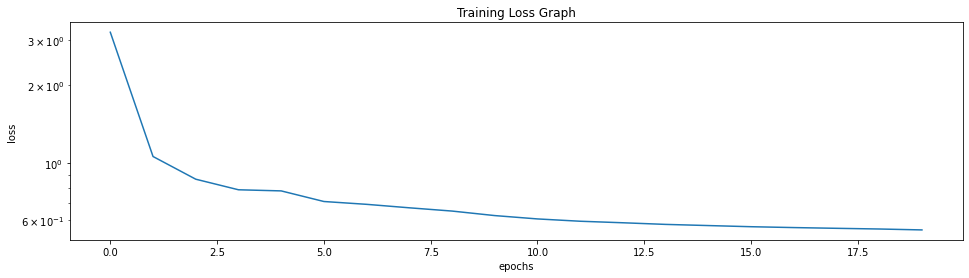

In [ ]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [ ]:
def inference(dataset, model, batch_size): # 추론
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy()) # 예측값과 정답값의 차이를 기록
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )
   

In [ ]:
%%time
MODEL.eval() # nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
valid_CHECK_TS, valid_CHECK_DIST, valid_CHECK_ATT = inference(validation_data, MODEL, BATCH_SIZE)
# CHECK_DIST = 모든 시간대에서 전체 feature(field) 차이

CPU times: user 4.15 s, sys: 56 ms, total: 4.2 s
Wall time: 4.22 s


In [ ]:
valid_ANOMALY_SCORE = np.mean(valid_CHECK_DIST, axis=1)
# 그 차이의 평균을 스코어 지수로 표현
valid_ANOMALY_SCORE.mean()

0.0056821094

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):# plot은 몇개 plot으로 그림 그려줄지 정하는거
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

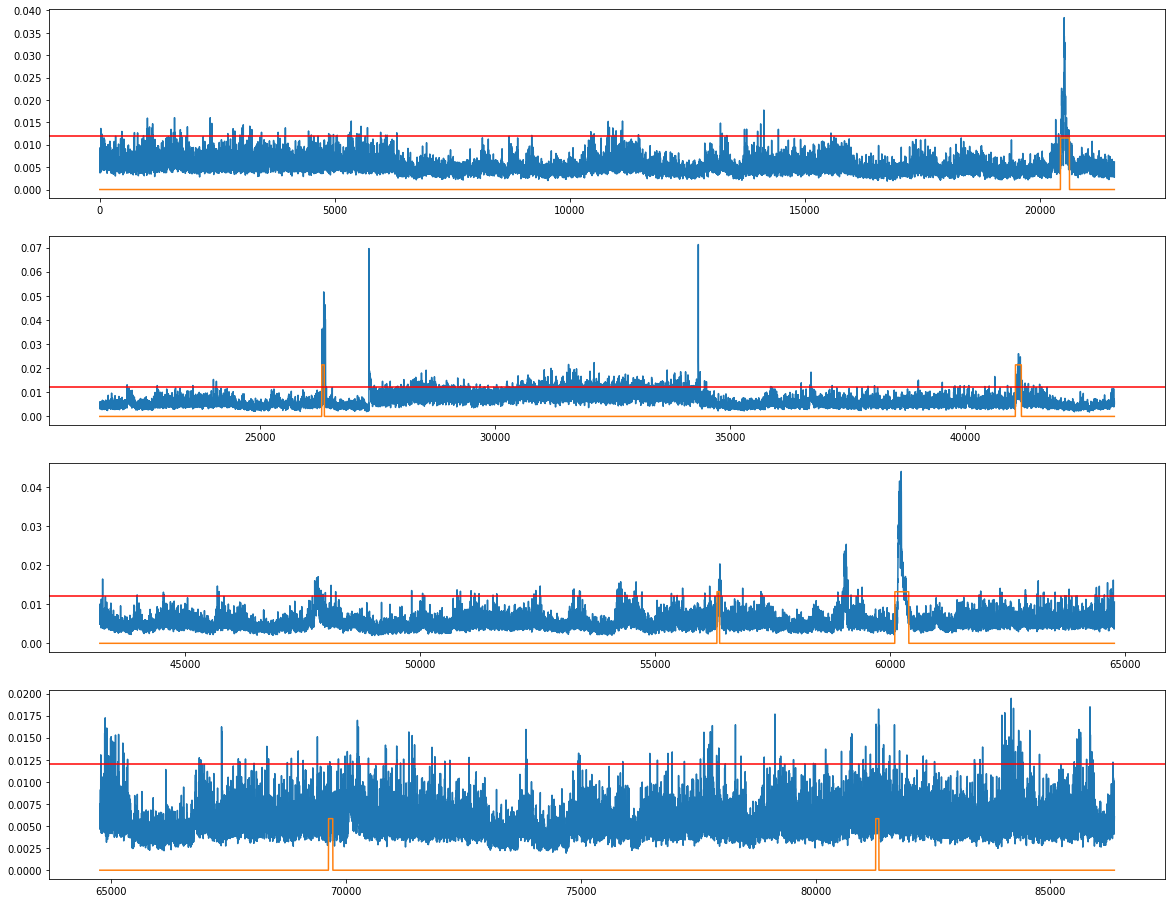

In [ ]:
# 초기 Threshold 세팅(그래프보면서,)
THRESHOLD = 0.0120
check_graph(valid_ANOMALY_SCORE, valid_CHECK_ATT, piece=4, THRESHOLD=THRESHOLD)

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

    #Threshold보다 distance가 크면 Attack 으로 간주하는 식

In [ ]:
LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [ ]:
# 탐지 모델 - 윈도우 방식

# 첫 시작의 몇 초는 판단을 내릴 수 없고 (예전 MA 식 만든거 생각해보면됨)
# 데이터셋 불연속 시간 구간 체크 어려움
# 위에서 보시는 바와 같이 정답에 비해 얻어낸 label의 수가 적습니다.



In [ ]:
#정상은 0 비정상 1
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [ ]:
for i in trange(1000):
  THRESHOLD = 0.01900+i*0.0001
  LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
  ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)
  FINAL_LABELS = fill_blank(valid_CHECK_TS, LABELS, np.array(raw_validation['timestamp']))
  TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
  print(f"F1: {TaPR['f1']:.4f} (TaP: {TaPR['TaP']:.4f}, TaR: {TaPR['TaR']:.4f}) Threshold = {THRESHOLD:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

F1: 0.1611 (TaP: 0.1136, TaR: 0.2770) Threshold = 0.01890
F1: 0.1638 (TaP: 0.1162, TaR: 0.2770) Threshold = 0.01900
F1: 0.1628 (TaP: 0.1158, TaR: 0.2744) Threshold = 0.01910
F1: 0.1642 (TaP: 0.1172, TaR: 0.2744) Threshold = 0.01920
F1: 0.1462 (TaP: 0.1003, TaR: 0.2695) Threshold = 0.01930
F1: 0.1475 (TaP: 0.1016, TaR: 0.2687) Threshold = 0.01940
F1: 0.1501 (TaP: 0.1041, TaR: 0.2687) Threshold = 0.01950
F1: 0.1501 (TaP: 0.1044, TaR: 0.2672) Threshold = 0.01960
F1: 0.1502 (TaP: 0.1050, TaR: 0.2633) Threshold = 0.01970
F1: 0.1482 (TaP: 0.1038, TaR: 0.2590) Threshold = 0.01980
F1: 0.1493 (TaP: 0.1051, TaR: 0.2577) Threshold = 0.01990
F1: 0.1471 (TaP: 0.1035, TaR: 0.2539) Threshold = 0.02000
F1: 0.1481 (TaP: 0.1047, TaR: 0.2530) Threshold = 0.02010
F1: 0.1487 (TaP: 0.1055, TaR: 0.2519) Threshold = 0.02020
F1: 0.1493 (TaP: 0.1068, TaR: 0.2477) Threshold = 0.02030
F1: 0.1448 (TaP: 0.1061, TaR: 0.2282) Threshold = 0.02040
F1: 0.1463 (TaP: 0.1076, TaR: 0.2282) Threshold = 0.02050
F1: 0.1472 (Ta

KeyboardInterrupt: ignored

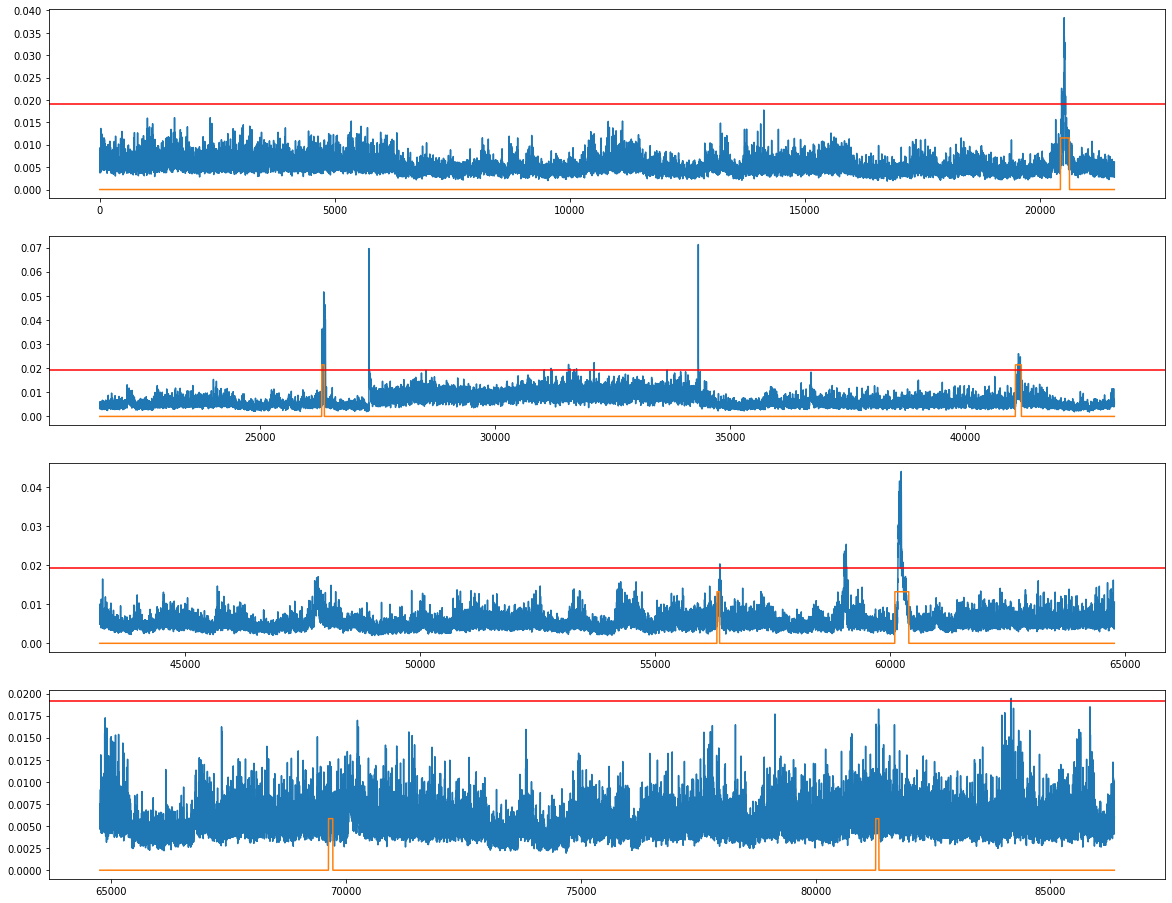

CPU times: user 12.3 s, sys: 372 ms, total: 12.6 s
Wall time: 12.3 s


In [ ]:
%%time
# 0.01970,0.02120
THRESHOLD = 0.01920
check_graph(valid_ANOMALY_SCORE, valid_CHECK_ATT, piece=4, THRESHOLD=THRESHOLD)
###### valid_test용 #################
LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)


FINAL_LABELS = fill_blank(valid_CHECK_TS, LABELS, np.array(raw_validation['timestamp'])) # Labeling 진행
FINAL_LABELS.shape

## 평가

In [ ]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.4f} (TaP: {TaPR['TaP']:.4f}, TaR: {TaPR['TaR']:.4f}),Threshold : {THRESHOLD:.5f}")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}") # f1 score로 점수 받기

F1: 0.1642 (TaP: 0.1172, TaR: 0.2744),Threshold : 0.01920
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7faf115dd250>, <TaPR_pkg.DataManage.Range.Range object at 0x7faf141015d0>, <TaPR_pkg.DataManage.Range.Range object at 0x7faf1165bb10>, <TaPR_pkg.DataManage.Range.Range object at 0x7faf14101ed0>]


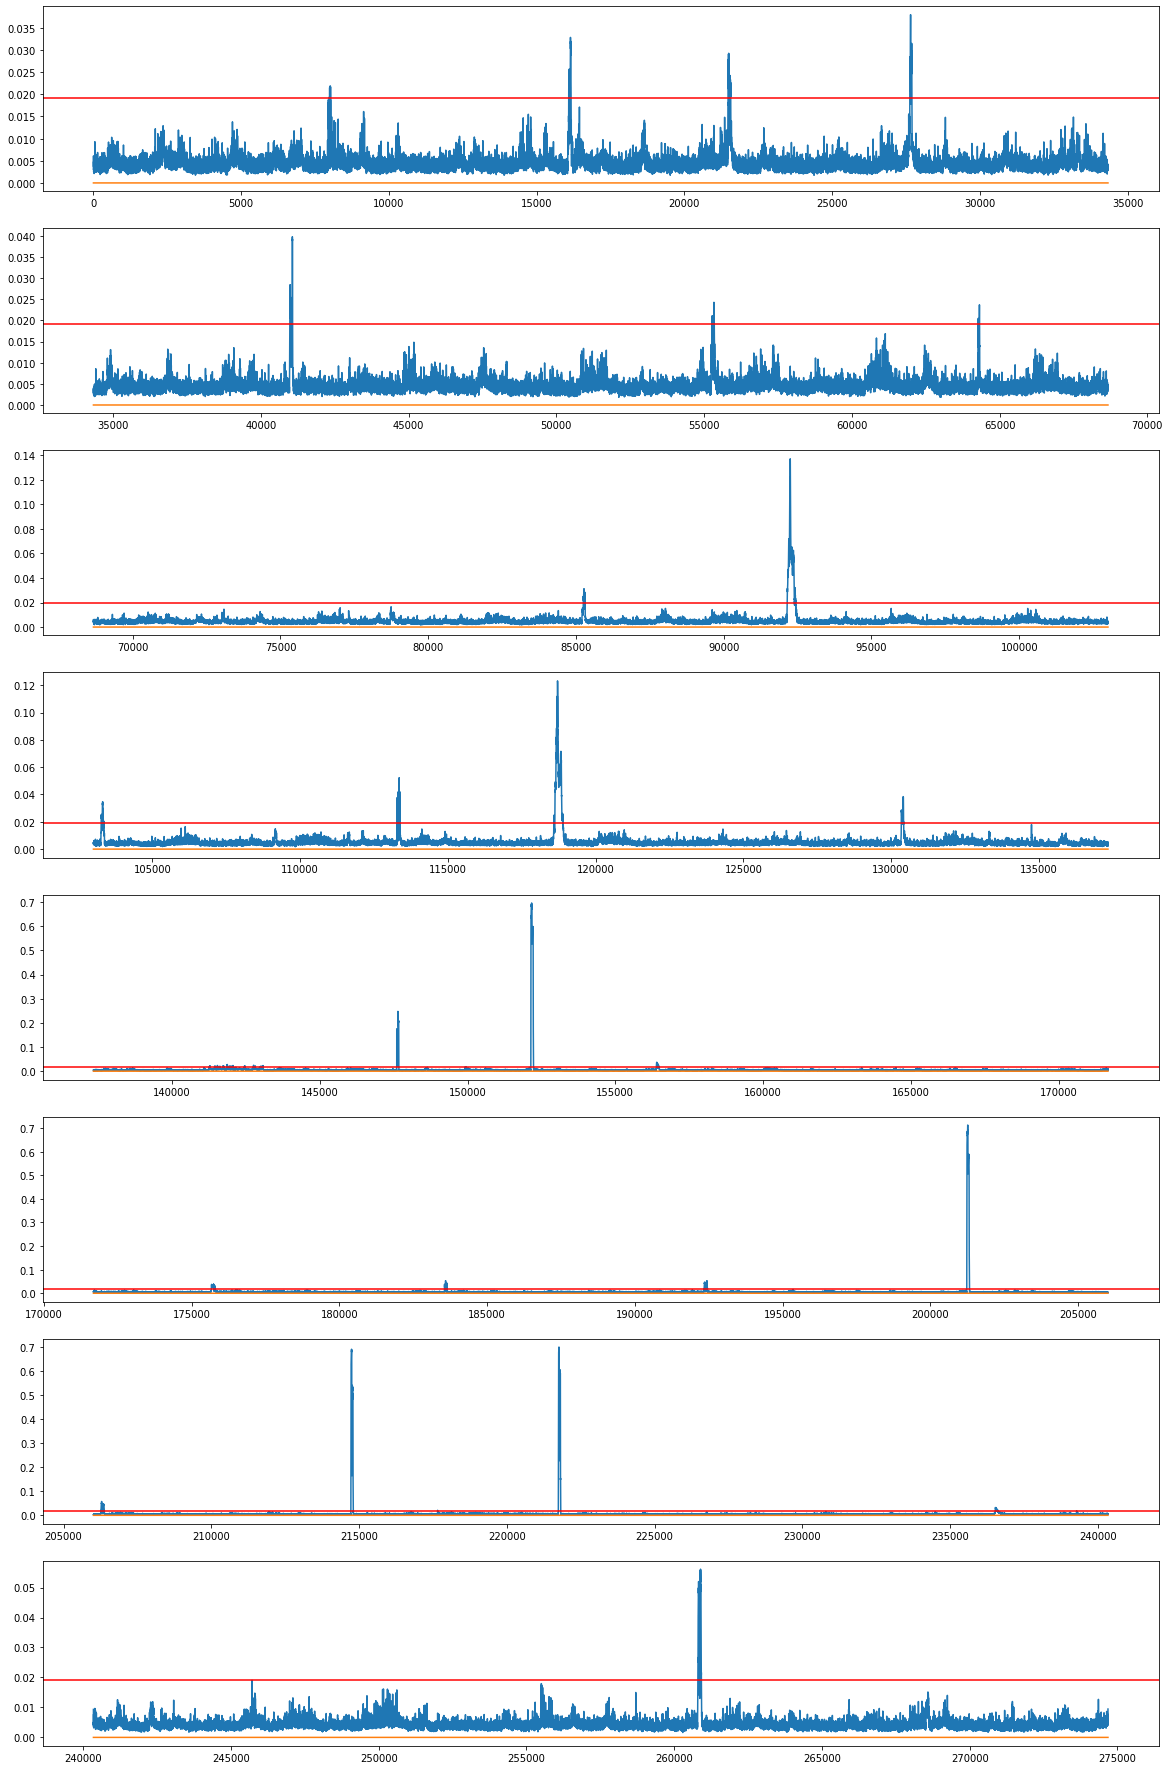

CPU times: user 14.2 s, sys: 764 ms, total: 14.9 s
Wall time: 14.2 s


In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(test_data, MODEL, BATCH_SIZE)

ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

check_graph(ANOMALY_SCORE, CHECK_ATT, piece=8, THRESHOLD=THRESHOLD)

LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

## 저장

In [ ]:
submission = pd.read_csv('./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission.to_csv('./gdrive/MyDrive/멋사_study/HAICon2021/Submission/submission_W{}_B{}_P{}_D{}_E{}_T{}.csv'.format(WINDOW_SIZE,BATCH_SIZE,N_HIDDENS,N_LAYERS,n_epochs,THRESHOLD), index=False)
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0
